In [ ]:
!pip install datasets transformers

In [ ]:
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer
from datasets import load_dataset
from tqdm import tqdm
from torch.nn.utils.rnn import pad_sequence
import random

In [ ]:
class OntoNotesDataset(Dataset):
    def __init__(self, split, tokenizer_name='bert-base-uncased', max_length=512):
        self.dataset = load_dataset('conll2012_ontonotesv5', 'english_v12', split=split)
        self.tokenizer = AutoTokenizer.from_pretrained(tokenizer_name, use_fast=True)
        self.max_length = max_length
        self.pairs = self.prepare_pairs()

    def prepare_pairs(self):
        pairs = []
        false_sample_count = 0
        true_sample_count = 0
        for item in self.dataset:
            document = item['sentences']
            coreference_spans = {}
            sentences = {}
            sentence_id = 1
            for sentence in document:
                words = sentence['words']
                coref_spans = sentence['coref_spans']
                for span in coref_spans:
                    entity_id, start, end = span
                    if entity_id not in coreference_spans:
                        coreference_spans[entity_id] = []
                    coreference_spans[entity_id].append([sentence_id, words[start:end+1]])
                sentences[sentence_id] = words
                sentence_id += 1


            for entity_id in coreference_spans.keys():
                spans_of_entity = coreference_spans[entity_id]

                n = len(spans_of_entity)

                if n % 2 != 0: 
                    n -= 1  
                for i in range(0, n, 2):
                    span1 = spans_of_entity[i]
                    span2 = spans_of_entity[i + 1]
                    sentence1 = sentences[span1[0]]
                    words_sentence_1 = span1[1]
                    sentence2 = sentences[span2[0]]
                    words_sentence_2 = span2[1]
                    pairs.append([sentence1, words_sentence_1, sentence2, words_sentence_2, 1])
                    true_sample_count+=1

                false_entities = [eid for eid in coreference_spans.keys() if eid != entity_id]
                if (len(false_entities) > 0):
                  for i in range(0, n, 2):
                      span1 = spans_of_entity[i]
                      sentence1 = sentences[span1[0]]
                      words_sentence_1 = span1[1]
                      span2 = random.choice(coreference_spans[random.choice(false_entities)])
                      sentence2 = sentences[span2[0]]
                      words_sentence_2 = span2[1]
                      pairs.append([sentence1, words_sentence_1, sentence2, words_sentence_2, 0])
                      false_sample_count+=1
        return pairs

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        two_sentence = self.pairs[idx]
        sentence_one = two_sentence[0]
        word_one = two_sentence[1]
        sentence_two = two_sentence[2]
        word_two = two_sentence[3]
        label = two_sentence[4]

        sentence_one_text = ' '.join(sentence_one)
        sentence_two_text = ' '.join(sentence_two)
        word_one_text = ' '.join(word_one)
        word_two_text = ' '.join(word_two)

        input_sequence = f"[CLS] {sentence_one_text} [SEP] {sentence_two_text} [SEP] {word_one_text} [SEP] {word_two_text} [SEP]"
        tokenized_inputs = self.tokenizer(input_sequence, return_tensors='pt', padding='max_length', truncation=True, max_length=self.max_length)
        return {
            'input_ids': tokenized_inputs['input_ids'].squeeze(0),
            'attention_mask': tokenized_inputs['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.long)
        }


def collate_fn(batch):
    input_ids = [item['input_ids'] for item in batch] 
    attention_masks = [item['attention_mask'] for item in batch]  
    labels = torch.tensor([item['label'] for item in batch])  

    input_ids_padded = pad_sequence(input_ids, batch_first=True, padding_value=0)  
    attention_masks_padded = pad_sequence(attention_masks, batch_first=True, padding_value=0)

    return {
        'input_ids': input_ids_padded,
        'attention_mask': attention_masks_padded,
        'label': labels
    }

In [ ]:
class OntoNotesDatasetTest(Dataset):
    def __init__(self, split='test', tokenizer_name='bert-base-uncased', max_length=512):
        self.dataset = load_dataset('conll2012_ontonotesv5', 'english_v12', split=split)
        self.tokenizer = AutoTokenizer.from_pretrained(tokenizer_name, use_fast=True)
        self.max_length = max_length
        self.pairs, self.combination_lengths = self.prepare_pairs()

    def prepare_pairs(self):
        pairs = []
        entity_count = 0
        combination_lengths = []
        for item in self.dataset:
            document = item['sentences']
            coreference_spans = {}
            sentences = {}
            sentence_id = 1
            for sentence in document:
                words = sentence['words']
                coref_spans = sentence['coref_spans']
                for span in coref_spans:
                    entity_id, start, end = span
                    if entity_id not in coreference_spans:
                        coreference_spans[entity_id] = []
                    coreference_spans[entity_id].append([sentence_id, words[start:end+1]])
                sentences[sentence_id] = words
                sentence_id += 1

            entity_count += len(coreference_spans.keys())
            for entity_id in coreference_spans.keys():
                spans_of_entity = coreference_spans[entity_id]
                n = len(spans_of_entity)
                if n % 2 != 0: 
                    n -= 1 
                for i in range(0, n, 2): 
                    span1 = spans_of_entity[i]
                    span2 = spans_of_entity[i + 1]
                    sentence1 = sentences[span1[0]]
                    words_sentence_1 = span1[1]
                    sentence2 = sentences[span2[0]]
                    words_sentence_2 = span2[1]
                    combination_len = 0
                    for word in sentence2:
                      if word not in words_sentence_2:
                        pairs.append([sentence1, words_sentence_1, sentence2, [word], 0])
                        combination_len+=1
                    pairs.append([sentence1, words_sentence_1, sentence2, words_sentence_2, 1])
                    combination_len+=1
                    combination_lengths.append(combination_len)
        return pairs, combination_lengths

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        two_sentence = self.pairs[idx]
        sentence_one = two_sentence[0]
        word_one = two_sentence[1]
        sentence_two = two_sentence[2]
        word_two = two_sentence[3]
        label = two_sentence[4]
        sentence_one_text = ' '.join(sentence_one)
        sentence_two_text = ' '.join(sentence_two)
        word_one_text = ' '.join(word_one)
        word_two_text = ' '.join(word_two)



        input_sequence = f"[CLS] {sentence_one_text} [SEP] {sentence_two_text} [SEP] {word_one_text} [SEP] {word_two_text} [SEP]"
        tokenized_inputs = self.tokenizer(input_sequence, return_tensors='pt', padding='max_length', truncation=True, max_length=self.max_length)
        return {
            'input_ids': tokenized_inputs['input_ids'].squeeze(0),
            'attention_mask': tokenized_inputs['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.long),
        }


def collate_fn(batch):
    input_ids = [item['input_ids'] for item in batch]  
    attention_masks = [item['attention_mask'] for item in batch]  
    labels = torch.tensor([item['label'] for item in batch])  

    input_ids_padded = pad_sequence(input_ids, batch_first=True, padding_value=0) 
    attention_masks_padded = pad_sequence(attention_masks, batch_first=True, padding_value=0) 

    return {
        'input_ids': input_ids_padded,
        'attention_mask': attention_masks_padded,
        'label': labels,
    }


In [ ]:
from transformers import BertModel, BertPreTrainedModel
import torch.nn as nn

class CorefResolver(BertPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.bert = BertModel(config)
        self.classifier = nn.Sequential(
            nn.Dropout(config.hidden_dropout_prob),
            nn.Linear(config.hidden_size, 256),
            nn.ReLU(),
            nn.Dropout(config.hidden_dropout_prob),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        sequence_output = outputs[0]
        logits = self.classifier(sequence_output).squeeze()

        if(len(logits.shape)>1):
          logits = torch.mean(logits, dim = 1)
        else:
          logits = torch.mean(logits, dim = 0)
        loss = None
        if labels is not None:
            loss_fct = nn.BCELoss()
            logits = logits.view(-1)  
            loss = loss_fct(logits, labels.float())  

        return (loss, logits) if loss is not None else logits

In [ ]:
from torch.optim import Adam
import os

dataset = OntoNotesDataset(split='train', tokenizer_name='bert-base-uncased', max_length=512)
data_loader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
model = CorefResolver.from_pretrained('bert-base-uncased')
optimizer = Adam(model.parameters(), lr=1e-5)

def train(model, data_loader, optimizer, epochs=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.train()

    for epoch in range(epochs):
        total_loss = 0
        progress_bar = tqdm(data_loader, desc=f"Epoch {epoch+1}", leave=False)

        for batch in progress_bar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            optimizer.zero_grad()
            try:
                loss, _ = model(input_ids, attention_mask, labels)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
                progress_bar.set_postfix(loss=f"{total_loss / (progress_bar.last_print_n + 1):.4f}")

            except RuntimeError as e:
                print(f"Error during training: {str(e)}")
                continue

        avg_loss = total_loss / len(data_loader)
        print(f"Epoch {epoch+1}: Average Loss = {avg_loss:.4f}")

        save_path = 'drive/MyDrive/COMP442FinalProject/models'
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        model_save_path = os.path.join(save_path, f"conll_baseline_epoch_{epoch}.pt")
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
        }, model_save_path)
        print(f"Model saved to {model_save_path}")


train(model, data_loader, optimizer, epochs=1)

## Span Index Prediction

In [ ]:
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt

def evaluate_model(model, data_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()


    thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]
    metrics = {
        "Accuracy": [],
        "Precision": [],
        "Recall": [],
        "F1 Score": []
    }

    with torch.no_grad():
        for threshold in thresholds:
            y_pred = []
            y_true = []
            a = 0
            for batch in tqdm(data_loader, desc=f"Evaluating for threshold {threshold}"):
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['label'].to(device)

                logits = model(input_ids, attention_mask)
                pred_labels = (logits > threshold).cpu().numpy()
                y_pred.append(pred_labels)
                y_true.append(labels.cpu().numpy())
                a+=1
                if a == 1000:
                  break

            accuracy = accuracy_score(y_true, y_pred)
            precision = precision_score(y_true, y_pred, zero_division=0)
            recall = recall_score(y_true, y_pred, zero_division=0)
            f1 = f1_score(y_true, y_pred, zero_division=0)

            metrics["Accuracy"].append(accuracy)
            metrics["Precision"].append(precision)
            metrics["Recall"].append(recall)
            metrics["F1 Score"].append(f1)


    return metrics



model = CorefResolver.from_pretrained('bert-base-uncased')
model_save_path = 'drive/MyDrive/COMP442FinalProject/models/conll_baseline_epoch_1.pt'
checkpoint = torch.load(model_save_path, map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model_state_dict'])

dataset_test = OntoNotesDatasetTest(split='test', tokenizer_name='bert-base-uncased', max_length=512)
loader_test = DataLoader(dataset_test, batch_size=1, shuffle=False, collate_fn=collate_fn)

metrics = evaluate_model(model, loader_test)


# **Binary classification on mention pairs**

Some weights of CorefResolver were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.1.bias', 'classifier.1.weight', 'classifier.4.bias', 'classifier.4.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


211120
211120


Evaluating:   0%|          | 0/211120 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/211120 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/211120 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/211120 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/211120 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/211120 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/211120 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/211120 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/211120 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/211120 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/211120 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/211120 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/211120 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/211120 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/211120 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/211120 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/211120 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/211120 [00:00<?, ?it/s]

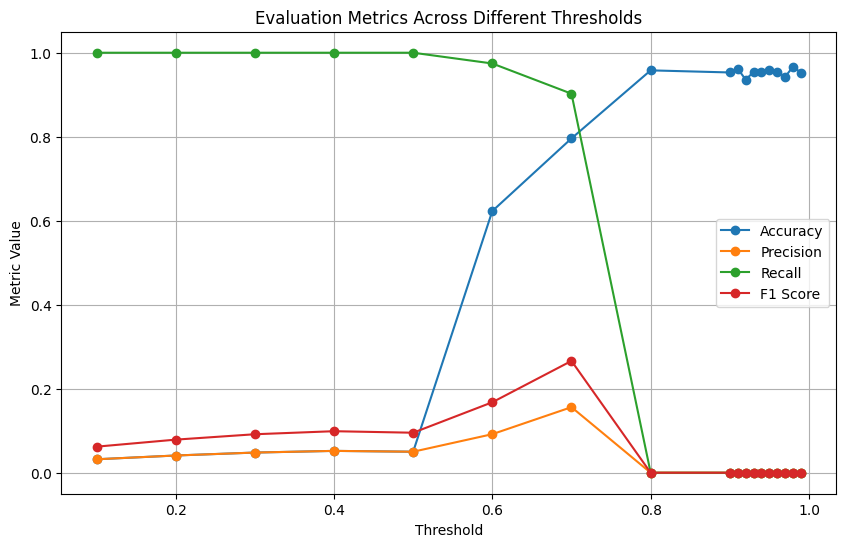

Evaluation Results: {'Accuracy': [0.032, 0.041, 0.048, 0.052, 0.05, 0.623, 0.796, 0.958, 0.953, 0.962, 0.936, 0.954, 0.954, 0.958, 0.954, 0.943, 0.967, 0.952], 'Precision': [0.032, 0.041, 0.048, 0.052, 0.05, 0.09178743961352658, 0.15611814345991562, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'Recall': [1.0, 1.0, 1.0, 1.0, 1.0, 0.9743589743589743, 0.9024390243902439, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'F1 Score': [0.06201550387596899, 0.0787704130643612, 0.0916030534351145, 0.0988593155893536, 0.09523809523809523, 0.16777041942604856, 0.2661870503597123, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}


In [ ]:
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

def evaluate_model(model, data_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval() 

    thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]
    metrics = {
        "Accuracy": [],
        "Precision": [],
        "Recall": [],
        "F1 Score": []
    }

    with torch.no_grad():
      for threshold in thresholds:
        y_pred = []
        y_true = []
        a = 0
        for batch in tqdm(data_loader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            logits = model(input_ids, attention_mask)
            probabilities = torch.sigmoid(logits)
            predictions = (probabilities > threshold).float()
            y_pred.append(predictions.cpu().numpy())
            y_true.append(labels.cpu().numpy())
            a+=1
            if a == 1000:
              break
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, zero_division=0)
        recall = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)

        metrics["Accuracy"].append(accuracy)
        metrics["Precision"].append(precision)
        metrics["Recall"].append(recall)
        metrics["F1 Score"].append(f1)

    return metrics



model = CorefResolver.from_pretrained('bert-base-uncased')
model_save_path = 'drive/MyDrive/COMP442FinalProject/models/conll_baseline_epoch_1.pt'
checkpoint = torch.load(model_save_path, map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model_state_dict'])
dataset_test = OntoNotesDatasetTest(split='test', tokenizer_name='bert-base-uncased', max_length=512)
loader_test = DataLoader(dataset_test, batch_size=1, shuffle=True, collate_fn=collate_fn)

results = evaluate_model(model, loader_test)
print("Evaluation Results:", results)

In [ ]:
print(metrics)

NameError: name 'metrics' is not defined